# Uncertainty and sensitivity analyses

Using the Sensitivity Analysis Library [SALib](https://salib.readthedocs.io/en/latest/) in Python.

In [1]:
# Basic libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# From AeroMetric
from utils.functions import emission_profile_function
from metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from climate_models.gwpstar_climate_model import species_gwpstar_climate_model
from climate_models.lwe_climate_model import species_lwe_climate_model
from climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model

# Sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec

## 1. Wrap metrics calculation in function

In [2]:
def gwp_rf_function(time_horizon, sensitivity_rf):
    metric = 4.56e14 * sensitivity_rf / time_horizon**0.801
    return metric

def egwp_function(time_horizon, sensitivity_rf, ratio_erf_rf, efficacy_erf):
    metric = 4.56e14 * sensitivity_rf * ratio_erf_rf * efficacy_erf / time_horizon**0.801
    return metric

def ratr_function(time_horizon, sensitivity_rf, ratio_erf_rf, efficacy_erf):
    metric = 6.25e14 * sensitivity_rf * ratio_erf_rf * efficacy_erf / time_horizon**0.843
    return metric

In [3]:
def climate_metric_parametric(metric: str, time_horizon_range: np.linspace, sensitivity_rf, ratio_erf_rf, efficacy_erf):

    metrics_dict = {
        'gwp_rf': np.zeros(len(time_horizon_range)),
        'egwp_erf': np.zeros(len(time_horizon_range)),        
    }
    k = 0
    for time_horizon in time_horizon_range:

        metrics_dict['gwp_rf'][k], metrics_dict['egwp_erf'][k] = gwp_rf_function(time_horizon, sensitivity_rf), egwp_function(time_horizon, sensitivity_rf, ratio_erf_rf, efficacy_erf)
        
        k += 1
    
    return metrics_dict[metric]

## 2. Uncertainty analysis

### a) Define problem

In [4]:
# Define problem
sp1 = ProblemSpec({
    'names': ['sensitivity_rf', 'ratio_erf_rf', 'efficacy_erf'],
    'bounds': [
        [2.23e-12, 7.96e-13],
        [0.23, 0.87], 
        [0.12, 0.64]
    ],
    'dists': ['norm', 'unif', 'unif'],
})

sp2 = ProblemSpec({
    'names': ['sensitivity_rf', 'ratio_erf_rf', 'efficacy_erf'],
    'bounds': [
        [2.23e-12, 7.96e-13],
        [0.23, 0.87], 
        [0.12, 0.64]
    ],
    'dists': ['norm', 'unif', 'unif'],
})

### b) Run analysis

In [5]:
# Create wrapper for function
metric1='gwp_rf'
metric2='egwp_erf'
time_horizon_range=np.arange(15,110,5)

def wrapped_model1(params, metric=metric1, time_horizon_range=time_horizon_range):
    n_samples = params.shape[0]
    n_times = time_horizon_range.shape[0]
    results = np.empty((n_samples, n_times))
    
    for i in range(n_samples):
        results[i, :] = climate_metric_parametric(
            metric, 
            time_horizon_range, 
            *params[i]
        )
        
    return results

def wrapped_model2(params, metric=metric2, time_horizon_range=time_horizon_range):
    n_samples = params.shape[0]
    n_times = time_horizon_range.shape[0]
    results = np.empty((n_samples, n_times))
    
    for i in range(n_samples):
        results[i, :] = climate_metric_parametric(
            metric, 
            time_horizon_range, 
            *params[i]
        )
        
    return results
    
y_results = np.zeros((11, 4))
# Run all steps
for k in range(3,14):
    nb_samples = 2**k 

    (
        sp1.sample_sobol(nb_samples, calc_second_order=False)  
        .evaluate(wrapped_model1)
        .analyze_sobol()
    )
    (
        sp2.sample_sobol(nb_samples, calc_second_order=False)  
        .evaluate(wrapped_model2)
        .analyze_sobol()
    )

    y1 = sp1.results
    y2 = sp2.results
    
    y_results[k-3, 0] = np.mean(y1, axis=0)[-1]
    y_results[k-3, 1] = np.std(y1, axis=0)[-1]
    y_results[k-3, 2] = np.mean(y2, axis=0)[-1]
    y_results[k-3, 3] = np.std(y2, axis=0)[-1]    

C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [6]:
ratr = ratr_function(np.arange(15, 110, 5), 2.23e-12, 0.55, 0.38)

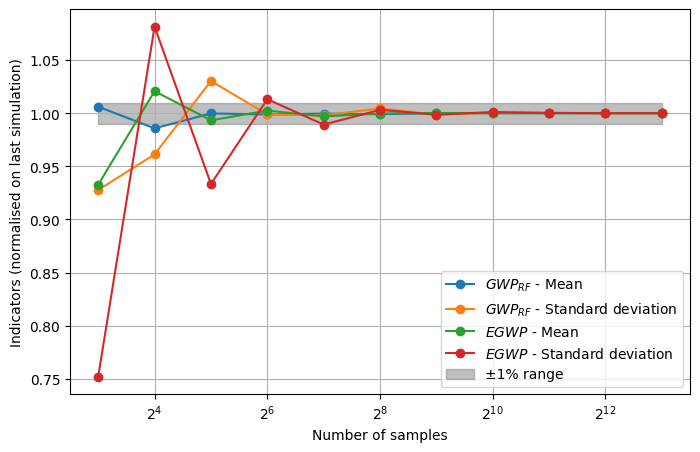

In [7]:
x = [2**i for i in range(3,14)]

plt.figure(figsize=(8, 5))
plt.plot(x, y_results[:,0]/y_results[-1,0], marker='o', label=r"$GWP_{RF}$ - Mean")
plt.plot(x, y_results[:,1]/y_results[-1,1], marker='o', label=r"$GWP_{RF}$ - Standard deviation")
plt.plot(x, y_results[:,2]/y_results[-1,2], marker='o', label=r"$EGWP$ - Mean")
plt.plot(x, y_results[:,3]/y_results[-1,3], marker='o', label=r"$EGWP$ - Standard deviation")
plt.fill_between(x, 0.99*np.ones(len(y_results[:,0])), 1.01*np.ones(len(y_results[:,0])), alpha = 0.5, color='grey', label="±1% range")
plt.xscale('log', base=2)
plt.legend()

plt.xlabel('Number of samples')
plt.ylabel('Indicators (normalised on last simulation)')
plt.grid(True)

plt.show()

### c) Plot

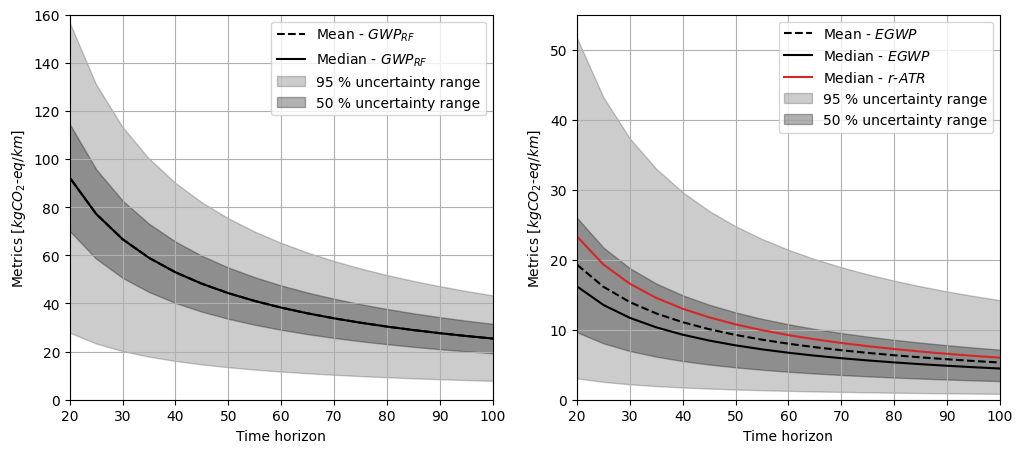

In [8]:
# Get model outputs (each output is a given time horizon)
y1 = sp1.results
y2 = sp2.results

# Set up figure
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Fig 1
axs[0].plot(time_horizon_range, np.mean(y1, axis=0), label=r"Mean - $GWP_{RF}$", color='black', linestyle='--')
axs[0].plot(time_horizon_range, np.median(y1, axis=0), label=r"Median - $GWP_{RF}$", color='black')

prediction_interval = 95
axs[0].fill_between(time_horizon_range,
                 np.percentile(y1, 50 - prediction_interval/2., axis=0),
                 np.percentile(y1, 50 + prediction_interval/2., axis=0),
                 alpha=0.2, color='black',
                 label=f"{prediction_interval} % uncertainty range")

prediction_interval = 50
axs[0].fill_between(time_horizon_range,
                 np.percentile(y1, 50 - prediction_interval/2., axis=0),
                 np.percentile(y1, 50 + prediction_interval/2., axis=0),
                 alpha=0.3, color='black',
                 label=f"{prediction_interval} % uncertainty range")

axs[0].set_xlabel("Time horizon")
axs[0].set_xlim(20, 100)
axs[0].set_ylim(0, 160)
axs[0].set_ylabel(r'Metrics [$kgCO_2\text{-}eq/km$]')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Fig 2
axs[1].plot(time_horizon_range, np.mean(y2, axis=0), label=r"Mean - $EGWP$", color='black', linestyle='--')
axs[1].plot(time_horizon_range, np.median(y2, axis=0), label=r"Median - $EGWP$", color='black')
axs[1].plot(time_horizon_range, ratr, label=r"Median - $r\text{-}ATR$", color='C3')

prediction_interval = 95
axs[1].fill_between(time_horizon_range,
                 np.percentile(y2, 50 - prediction_interval/2., axis=0),
                 np.percentile(y2, 50 + prediction_interval/2., axis=0),
                 alpha=0.2, color='black',
                 label=f"{prediction_interval} % uncertainty range")

prediction_interval = 50
axs[1].fill_between(time_horizon_range,
                 np.percentile(y2, 50 - prediction_interval/2., axis=0),
                 np.percentile(y2, 50 + prediction_interval/2., axis=0),
                 alpha=0.3, color='black',
                 label=f"{prediction_interval} % uncertainty range")

axs[1].set_xlabel("Time horizon")
axs[1].set_xlim(20, 100)
axs[1].set_ylim(0, 55)
axs[1].set_ylabel(r'Metrics [$kgCO_2\text{-}eq/km$]')
axs[1].legend(loc='upper right')
axs[1].grid(True)

plt.savefig("metric_uncertainties.pdf")
plt.show()